# How does population look like without the impact of the HIV/AIDS epidemic?
Modeling and Simulation - Project 1

Skye Ozga, HK Rho

### Reading the Data

In [599]:
#######NEW PROJECT########
#QUESTION: compare the actual data graph population to the graph without the HIV/AIDS epidemic 
#          so that we can see by what factor the population differs in two situations

from modsim import *
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library


def mean(x,y):
    return (x+y)/2

population change, birth rate, death rate change due to the aids epidemic in Sub-Saharan Africa

Question:
By what factor will the population change if the effects of the HIV/AIDS epidemic are disregarded compared to the actual population graph?

Methodology/Model:
The deaths caused by HIV/AIDS can be disregarded from the overall death rate of the entire population of the country we are analyzing, so that we can compare two situations with and without HIV/AIDS.

Results:
There is no results yet, but the results will consist of two graphs that each show the population change with and without HIV/AIDS.

Interpretation:
After generating the graphs, the amount by which one differs from the other can be observed/calculated.

In [600]:
country_list = ['Angola'    , 'Botswana', 'Eswatini'   , 'Lesotho' , 'Malawi', 
                'Mozambique', 'Namibia' , 'SouthAfrica', 'Zimbabwe', 'Zambia']

#years 1980-2030
T_START = 1980
T_1990  = 1990
T_2016  = 2016
T_END   = 2030
years = [x for x in range(1980,2017)];

#AIDS years: 1990-2016
years_AIDS = [x for x in range(1990,2017)];

In [601]:
class Country:
    
    def __init__(self, name, data = TimeSeries()):
        
        #store data for each country
        if not data.empty:
            self.name      = name
            self.br_data   = TimeSeries()
            self.dr_data   = TimeSeries()
            self.da        = TimeSeries()
            self.pop_data  = TimeSeries()            
            for t in range(T_START, T_2016 + 1):
                self.br_data[t] = data[name + 'BR'][t]
            for t in range(T_START, T_2016 + 1):
                self.da[t] = data[name + 'DA'][t]
            for t in range(T_START, T_2016 + 1):
                self.dr_data[t] = data[name + 'DR'][t]
            for t in range(T_START, T_2016 + 1):
                self.pop_data[t] = data[name + 'Pop'][t]
            self.br_array  = [self.br_data[y] for y in years]
            self.dr_array  = [self.dr_data[y] for y in years]
            self.pop       = TimeSeries()
        
            #initialize control and experimental br/dr
            self.br_AIDS_linear = TimeSeries()
            m1, b1 = np.polyfit(years, self.br_array,1)
            for t in linrange(T_START, T_END+1):
                self.br_AIDS_linear[t] = m1*(t) + b1
        
            self.dr_AIDS_linear = TimeSeries()
            m2, b2 = np.polyfit(years, self.dr_array,1)
            for t in linrange(T_START, T_END+1):
                self.dr_AIDS_linear[t] = m2*(t) + b2
        
            self.br_noAIDS = TimeSeries()
            for t in linrange(T_START, T_2016+1):
                self.br_noAIDS[t] = self.br_data[t]
                if t >= T_1990:
                    self.br_noAIDS[t] = self.br_data[t] + self.br_data[t] * self.da[t]/(1000.0*self.pop_data[t])
        
            self.br_array_noAIDS  = [self.br_noAIDS[y] for y in years]
            
            self.br_noAIDS_linear = TimeSeries()
            m3, b3 = np.polyfit(years, self.br_array_noAIDS, 1)
            for t in linrange(T_START, T_END+1):
                self.br_noAIDS_linear[t] = m3*(t) + b3
        
            self.dr_noAIDS = TimeSeries()
            for t in linrange(T_START, T_2016+1):
                self.dr_noAIDS[t] = self.dr_data[t]
                if t >= T_1990: 
                    self.dr_noAIDS[t] = self.dr_data[t] - 1000.0*self.da[t]/self.pop_data[t]
        
            self.dr_array_noAIDS  = [self.dr_noAIDS[y] for y in years]
            
            self.dr_noAIDS_linear = TimeSeries()
            m4, b4 = np.polyfit(years, self.dr_array_noAIDS, 1)
            for t in linrange(T_START, T_END+1):
                self.dr_noAIDS_linear[t] = m4*(t) + b4
        else:    
            self.name      = name
            self.br_data   = TimeSeries()
            self.dr_data   = TimeSeries()
            self.da        = TimeSeries()
            self.pop_data  = TimeSeries()
            self.br_array  = [0]
            self.dr_array  = [0]
            self.pop       = TimeSeries()
        
            self.br_AIDS_linear   = TimeSeries()
            self.dr_AIDS_linear   = TimeSeries()
            self.br_noAIDS_linear = TimeSeries()
            self.dr_noAIDS_linear = TimeSeries()
            
    def update(self, t, aids = True):
        if t == T_START:
            self.pop[t] = self.pop_data[t]
            return self.pop[t]
        self.pop[t] = self.pop[t-1]
        delta = 0
        if aids:
            delta = self.pop[t-1]*(self.br_AIDS_linear[t] - self.dr_AIDS_linear[t])/1000
        else:
            delta = self.pop[t-1]*(self.br_noAIDS_linear[t] - self.dr_noAIDS_linear[t])/1000
        
        self.pop[t] += delta
        
        return self.pop[t]
                
print('this cell worked!')
            

this cell worked!


In [616]:
def run_simulation(country, aids = True, start = T_START, end = T_END):
    results = TimeSeries()
    for t in range(start, end+1):
        results[t] = country.update(t, aids)
    if aids:
        plt.plot(country.pop, label = country.name + ' With AIDS')
    else:
        plt.plot(country.pop, label = country.name + ' Without AIDS')

In [603]:
BPDdata = pd.read_csv("BPD.csv", index_col = ['Year'], skiprows = 3, nrows = 57);

countries = [Country(c, BPDdata) for c in country_list];

print('this one too!')


this one too!


In [604]:
total = Country('Cumulative')

for t in range(T_START, T_2016+1):
    total.da[t]        = 0.0
    total.pop_data[t]  = 0.0
    for c in countries:
            total.pop_data[t] += c.pop_data[t]
            total.da[t]       += c.da[t]
            
for t in range(T_START, T_2016+1):
    total.br_data[t]          = 0.0
    total.dr_data[t]          = 0.0
    
    for c in countries:
        total.br_data[t]          += c.br_data[t]
        total.dr_data[t]          += c.dr_data[t]
            
    total.br_data[t]          = total.br_data[t] / 10.
    total.dr_data[t]          = total.dr_data[t] / 10.
    
        
for t in range(T_START, T_END+1):
    total.br_AIDS_linear[t]   = 0.0
    total.dr_AIDS_linear[t]   = 0.0
    total.br_noAIDS_linear[t] = 0.0
    total.dr_noAIDS_linear[t] = 0.0
    
    for c in countries:
        total.br_AIDS_linear[t]   += c.br_AIDS_linear[t]
        total.dr_AIDS_linear[t]   += c.dr_AIDS_linear[t]
        total.br_noAIDS_linear[t] += c.br_noAIDS_linear[t]
        total.dr_noAIDS_linear[t] += c.dr_noAIDS_linear[t]
        
    total.br_AIDS_linear[t]   = total.br_AIDS_linear[t] /10.
    total.dr_AIDS_linear[t]   = total.dr_AIDS_linear[t] /10.
    total.br_noAIDS_linear[t] = total.br_noAIDS_linear[t] /10.
    total.dr_noAIDS_linear[t] = total.dr_noAIDS_linear[t] /10.
    
countries.append(total)

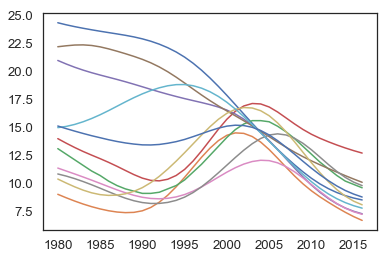

In [605]:
for c in countries:
    plt.plot(c.dr_data)

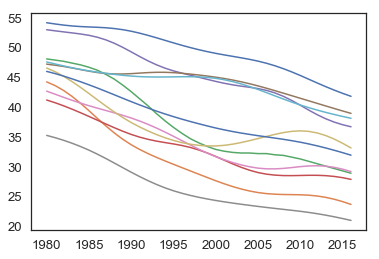

In [606]:
for c in countries:
    plt.plot(c.br_data)

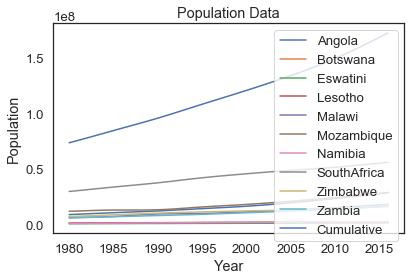

In [607]:
for c in countries:
    plt.plot(c.pop_data, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

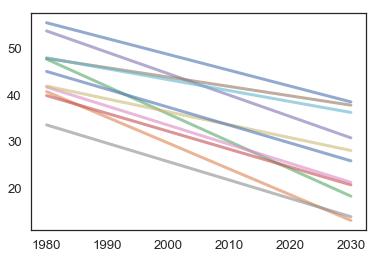

In [608]:
for c in countries:
    plot(c.br_AIDS_linear)


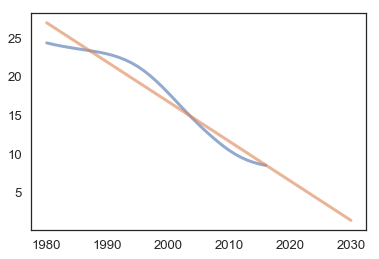

In [609]:
plot(countries[0].dr_data)
plot(countries[0].dr_AIDS_linear)

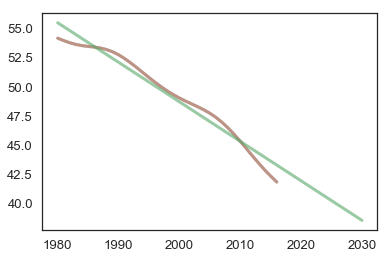

In [610]:
plot(countries[0].br_data)
plot(countries[0].br_noAIDS)
plot(countries[0].br_noAIDS_linear)

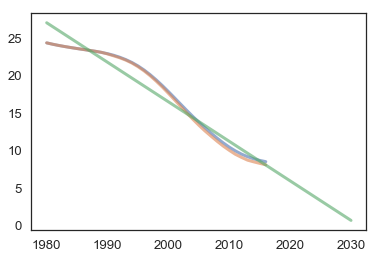

In [611]:
plot(countries[0].dr_data)
plot(countries[0].dr_noAIDS)
plot(countries[0].dr_noAIDS_linear)

In [612]:
#this is the revised death rate without the impact of the HIV/AIDS epidemic

#numDeaths = DR * pop
#newDR = (numDeaths - DA) / (pop + DA)
#and then use the newDR to model a population without HIV/AIDS


#this is the revised birth rate without the impact of the HIV/AIdS epidemic

#a is a random number which a% of the DA people give birth 
#a = random.randit(0,1)

#numBirths = BR * pop
#newBR = (a * numBirths) / (pop + DA)

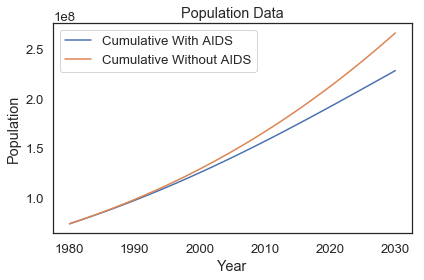

In [613]:
run_simulation(countries[10], True)
run_simulation(countries[10], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

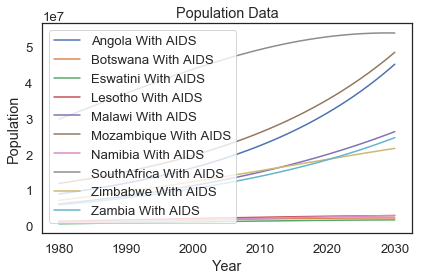

In [617]:
for i in range(10):
    run_simulation(countries[i], True)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

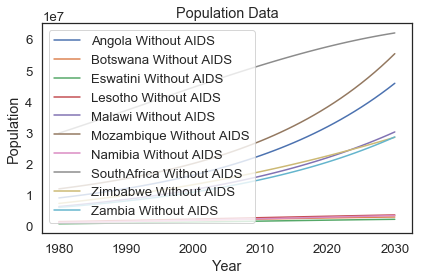

In [618]:
for i in range(10):
    run_simulation(countries[i], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

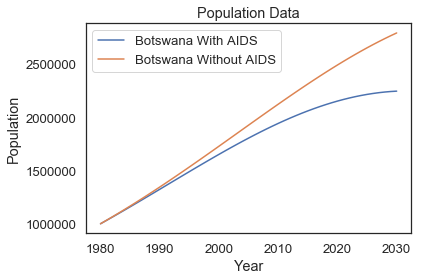

In [620]:
run_simulation(countries[1], True)
run_simulation(countries[1], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')